In [1]:
!pip3 install bayesian-optimization==0.6 --user

  Created wheel for bayesian-optimization: filename=bayesian_optimization-0.6.0-cp36-none-any.whl size=10827 sha256=54767842ebe23f8d8fd261138c8dbd42853fb26197c6100d6898424eea792149
  Stored in directory: /Users/bochmann/Library/Caches/pip/wheels/f5/ef/5c/9ff1d2d86ad1117bf4cd3f989356ae46fa907014ece63b09dd
Successfully built bayesian-optimization


I use `bayesian-optimization==0.6`, my backend pretty much stick with this version, so migrating will break the code.

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.25.1
numpy==1.17.1
matplotlib==3.1.1


In [3]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA Time Period: **Mar 23, 2018 - Mar 23, 2019**

In [4]:
df = pd.read_csv('../dataset/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-23,311.250000,311.250000,300.450012,301.540009,301.540009,6654900
1,2018-03-26,307.339996,307.589996,291.359985,304.179993,304.179993,8375200
2,2018-03-27,304.000000,304.269989,277.179993,279.179993,279.179993,13872000
3,2018-03-28,264.579987,268.679993,252.100006,257.779999,257.779999,21001400
4,2018-03-29,256.489990,270.959991,248.210007,266.130005,266.130005,15170700


In [5]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [6]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [7]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [8]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [9]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [10]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 20, 'skip': 2, 'population_size': 7, 'sigma': 0.9028243536088507, 'learning_rate': 0.3879939897462648, 'size_network': 339}
time taken to train: 2.0441651344299316 seconds
stop after 100 iteration with investment 45.564601
    1 | 00m02s |   45.56460 |          0.3880 |            6.8581 |    0.9028 |       338.7484 |    1.6348 |       19.6057 | 

Search parameters {'window_size': 5, 'skip': 4, 'population_size': 26, 'sigma': 0.4018633734777758, 'learning_rate': 0.31076392816648185, 'size_network': 703}
time taken to train: 4.034358978271484 seconds
stop after 100 iteration with investment 31.742502
    2 | 00m04s |   31.74250 |          0.3108 |           26.4018 |    0.4019 |       702.69

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
    3 | 00m06s |    0.00000 |          0.2519 |           37.2814 |    0.1267 |       454.3089 |    7.5680 |       45.4891 | 

Search parameters {'window_size': 40, 'skip': 2, 'population_size': 19, 'sigma': 0.31804088616817766, 'learning_rate': 0.21981098385767645, 'size_network': 985}
time taken to train: 11.194991111755371 seconds
stop after 100 iteration with investment 74.614202
    4 | 00m11s |   74.61420 |          0.2198 |           19.1910 |    0.3180 |       985.3289 |    2.4941 |       40.4560 | 

Search parameters {'window_size': 14, 'skip': 8, 'population_size': 22, 'sigma': 0.08194811515967527, 'learning_rate': 0.26810698402155136, 'size_network': 58}
stop after 100 iteration with investment 0.000000
    5 | 00m00s |    0.00000 |          0.2681 |           21.9885 |    0.0819 |        57.6591 |    8.1184 |       13.9074 | 

Search parameters {'window_size': 22, 'skip': 1, 'population_size': 34, 'sigma': 0.1971400576126662

time taken to train: 0.7075178623199463 seconds
stop after 100 iteration with investment 23.692702
   25 | 00m00s |   23.69270 |          0.4804 |            5.0341 |    0.4882 |       541.9436 |    3.7283 |        4.6074 | 

Search parameters {'window_size': 34, 'skip': 10, 'population_size': 17, 'sigma': 0.9354098635788418, 'learning_rate': 0.13391836992292683, 'size_network': 923}
time taken to train: 3.4444339275360107 seconds
stop after 100 iteration with investment 4.625800
   26 | 00m03s |    4.62580 |          0.1339 |           17.4316 |    0.9354 |       922.5780 |    9.8921 |       33.9410 | 

Search parameters {'window_size': 43, 'skip': 12, 'population_size': 6, 'sigma': 0.07329380542611583, 'learning_rate': 0.16802364902241784, 'size_network': 524}
stop after 100 iteration with investment 0.000000
   27 | 00m00s |    0.00000 |          0.1680 |            5.5497 |    0.0733 |       524.2915 |   11.6455 |       43.0858 | 

Search parameters {'window_size': 16, 'skip': 6, '

stop after 100 iteration with investment 0.000000
   46 | 00m04s |    0.00000 |          0.2798 |           22.8794 |    0.1615 |       849.5704 |    8.3496 |       42.3854 | 

Search parameters {'window_size': 26, 'skip': 3, 'population_size': 46, 'sigma': 0.3539094415408306, 'learning_rate': 0.251061179350553, 'size_network': 202}
time taken to train: 8.706244945526123 seconds
stop after 100 iteration with investment 48.100305
   47 | 00m09s |   48.10030 |          0.2511 |           45.8048 |    0.3539 |       202.4263 |    2.9580 |       25.8061 | 

Search parameters {'window_size': 24, 'skip': 11, 'population_size': 43, 'sigma': 0.721228288370273, 'learning_rate': 0.029837862554693253, 'size_network': 226}
time taken to train: 3.0091326236724854 seconds
stop after 100 iteration with investment 0.932499
   48 | 00m04s |    0.93250 |          0.0298 |           43.3582 |    0.7212 |       225.7233 |   11.1460 |       24.4614 | 

Search parameters {'window_size': 22, 'skip': 9, 'popu

time taken to train: 4.331695079803467 seconds
stop after 100 iteration with investment -11.378602
   68 | 00m06s |  -11.37860 |          0.0561 |           15.8159 |    0.0574 |       773.4302 |    1.8990 |        2.5977 | 

Search parameters {'window_size': 6, 'skip': 7, 'population_size': 22, 'sigma': 0.5497120739623604, 'learning_rate': 0.31661551027955326, 'size_network': 416}
time taken to train: 1.7729871273040771 seconds
stop after 100 iteration with investment 21.946804
   69 | 00m03s |   21.94680 |          0.3166 |           22.3891 |    0.5497 |       416.3528 |    7.2160 |        5.6909 | 

Search parameters {'window_size': 23, 'skip': 3, 'population_size': 45, 'sigma': 0.8226941942760242, 'learning_rate': 0.4711535833439536, 'size_network': 585}
time taken to train: 11.77226209640503 seconds
stop after 100 iteration with investment 41.046802
   70 | 00m13s |   41.04680 |          0.4712 |           45.2922 |    0.8227 |       585.4507 |    3.4976 |       22.9697 | 

Searc

In [11]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 83.683204
Best AGENT parameters:  {'window_size': 47.25402476735229, 'skip': 1.9681012530082038, 'population_size': 45.097880536622675, 'sigma': 0.2894482699847433, 'learning_rate': 0.1449943091564923, 'size_network': 987.2403757441558}


#### My selected parameters

In [12]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 9.946122884750366 seconds


82.94790257000001

#### bayesian parameters

In [13]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 29.448766946792603 seconds


72.77950270000004

#### My selected parameters

iter 100. reward: 94.843702
iter 200. reward: 102.799103
iter 300. reward: 109.669802
iter 400. reward: 109.063801
iter 500. reward: 116.030702
time taken to train: 50.246711015701294 seconds
day 2: buy 5 units at price 1395.899965, total balance 8604.100035
day 3: buy 5 units at price 1288.899995, total balance 7315.200040
day 4: buy 5 units at price 1330.650025, total balance 5984.550015
day 5: buy 5 units at price 1262.399980, total balance 4722.150035
day 6: buy 5 units at price 1337.649995, total balance 3384.500040
day 8, sell 5 units at price 1528.600005, investment 9.506415 %, total balance 4913.100045,
day 9, sell 5 units at price 1496.499940, investment 16.106753 %, total balance 6409.599985,
day 10: buy 1 units at price 289.660004, total balance 6119.939981
day 15, sell 5 units at price 1456.049955, investment 9.423960 %, total balance 7575.989936,
day 16, sell 5 units at price 1438.450010, investment 13.945662 %, total balance 9014.439946,
day 17: buy 1 units at price 293.3

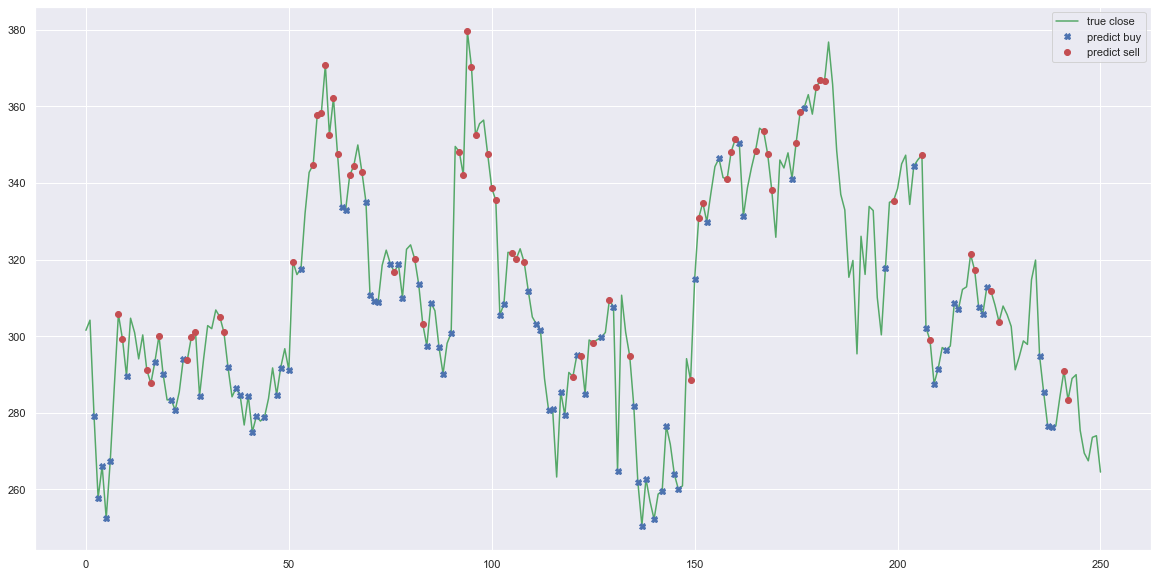

In [14]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

iter 100. reward: 75.468702
iter 200. reward: 84.518005
iter 300. reward: 89.965704
iter 400. reward: 91.548304
iter 500. reward: 91.830504
time taken to train: 147.1590929031372 seconds
day 4: buy 5 units at price 1330.650025, total balance 8669.349975
day 6: buy 5 units at price 1337.649995, total balance 7331.699980
day 10: buy 1 units at price 289.660004, total balance 7042.039976
day 14, sell 5 units at price 1501.699980, investment 12.854616 %, total balance 8543.739956,
day 16, sell 5 units at price 1438.450010, investment 7.535605 %, total balance 9982.189966,
day 18: buy 5 units at price 1500.399935, total balance 8481.790031
day 20: buy 5 units at price 1416.849975, total balance 7064.940056
day 24: buy 5 units at price 1470.399935, total balance 5594.540121
day 26: buy 1 units at price 299.920013, total balance 5294.620108
day 28: buy 5 units at price 1422.250060, total balance 3872.370048
day 30, sell 5 units at price 1513.849945, investment 422.629954 %, total balance 5386

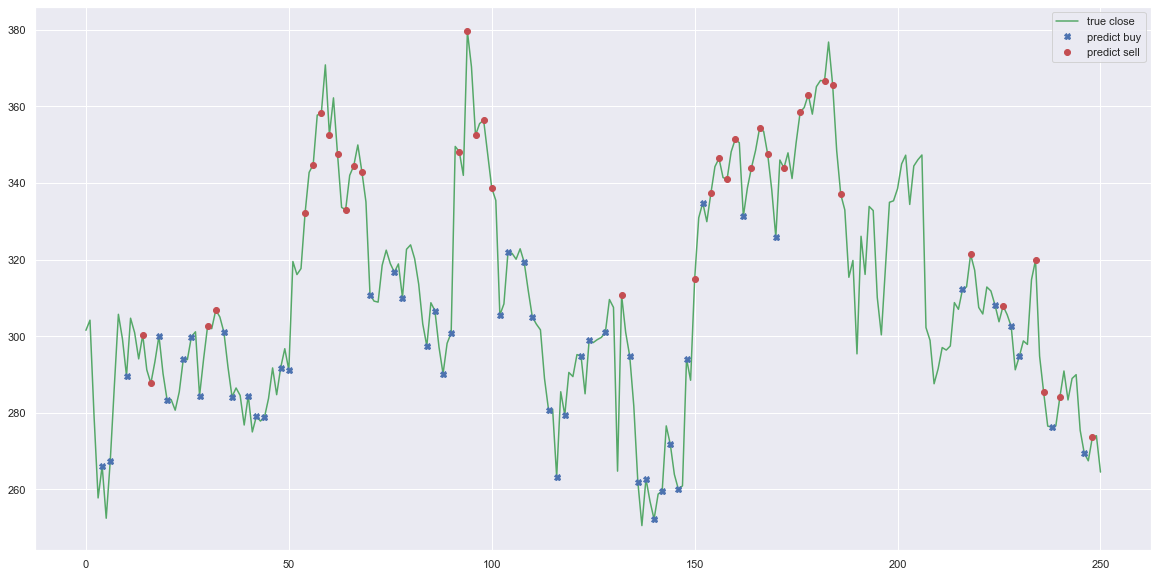

In [15]:
model = Model(input_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
              sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
              learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])))
agent.fit(500, 100)
agent.buy()